In [1]:
!pip install -qr ../requirements.txt

ERROR: torchvision 0.6.1 has requirement torch==1.5.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: Cannot uninstall 'pycurl'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [5]:
!pip install pyclustertend

  Using cached https://files.pythonhosted.org/packages/a3/67/5dd390479122860d3f0ea947e45561c6d4469edf912f8838a4747fe6e189/pyclustertend-1.4.9-py3-none-any.whl


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
import nltk

from transformers import AutoTokenizer, AutoModel

from collections import OrderedDict

from sklearn.preprocessing import scale
from pyclustertend import hopkins, ivat, vat

In [10]:
tokenizer = AutoTokenizer.from_pretrained("./LaBSE")
model = AutoModel.from_pretrained("./LaBSE")
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladyslavyelisieiev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [244]:
class TfIdfModel(object):
    def __init__(self, mode, random_state=42):
        self.mode = mode
        self.random_state = random_state
        self.clusterizer = None

    def _sep_sentences(self, text):
        """Split text into sentences."""
        return nltk.tokenize.sent_tokenize(text)

    def check_joined_words(self, sent):
        return any([len(word) > 20 for word in sent.split(" ")])

    def filter_sentances(self, sentances):
        sentances = [sent for sent in sentances if not self.check_joined_words(sent)]
        sentances = [
            sent
            for sent in sentances
            if len(sent.split(" ")) > 10
        ]
        return sentances

    def clean_sentances(self, sentances):
        return [sent.lower() for sent in sentances]

    def get_tfidf_sent_vector(self, sentances):
        tfidf_word = TfidfVectorizer(ngram_range=(1, 4), min_df=2, binary=False)
        tfidf_char = TfidfVectorizer(
            ngram_range=(2, 5),
            min_df=5,
            binary=False,
            analyzer="char",
            max_features=500,
        )
        text_vectorizer = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])

        return text_vectorizer.fit_transform(sentances).todense()

    def _clusterize(self, sent_vectors, n_sentences=5):
        """Get main context sentences for Extraction-based summarization"""
        if self.mode == "gmm":
            model = GaussianMixture(
                n_components=n_sentences, random_state=self.random_state
            ).fit(sent_vectors)
            self.clusterizer = model
            return model.means_
        elif self.mode == "kmeans":
            model = KMeans(n_clusters=n_sentences, random_state=self.random_state).fit(
                sent_vectors
            )
            self.clusterizer = model
            return model.cluster_centers_
        elif self.mode == "agglomirate":
            model = AgglomerativeClustering(n_clusters=n_sentences).fit(sent_vectors)
            self.clusterizer = model
            clusters = [sent_vectors[model.labels_ == i] for i in range(n_sentences)]
            centers = np.array([np.mean(cl, axis=(0)) for cl in clusters])
            return centers
        else:
            raise NotImplementedError('Try mode="gmm" or mode="kmeans"')

    def _get_summary(self, sent_vectors, centroids, sentences):
        selected_sentences = []
        for c in centroids:
            sent_idx = np.argmin([np.linalg.norm(c - vec) for vec in sent_vectors])
            selected_sentences.append(sentences[sent_idx])

        summary = list(OrderedDict.fromkeys(selected_sentences))
        summary.sort(key=lambda i: sentences.index(i))
        return "\n".join(summary)
    
    def _get_statistics(self, sent_vectors):
        embeds = np.array(sent_vectors)
        hop = hopkins(embeds, embeds.shape[0])
        vati = vat(embeds, return_odm=True)
        ivati = ivat(embeds, return_odm=True)
        labels = self.clusterizer.fit_predict(embeds)
        silhouette = silhouette_score(embeds, labels, metric="euclidean")
        return hop, silhouette, vati, ivati

    def __call__(self, text, n_sentences=5):
        sentences = self._sep_sentences(text)
        sentences = self.filter_sentances(sentences)
        cl_sentences = self.clean_sentances(sentences)
        sent_vectors = self.get_tfidf_sent_vector(cl_sentences)
        centroids = self._clusterize(sent_vectors, n_sentences)
        summary = self._get_summary(sent_vectors, centroids, sentences)
        hopkins_criterion, silhouette, vatimg, ivatimg = self._get_statistics(sent_vectors)
        
        p1 = get_vat_plot(vatimg, "Visual assessment of cluster tendency")
        p2 = get_vat_plot(ivatimg, "iVAT")
        p = row(p1, p2)
        html = file_html(p, CDN, "ivat")
        result = {
            "Summary": summary,
            "Metrics": {"Hopkins": hopkins_criterion, "Silhouette": silhouette},
            "Figures": {"html": html},
        }
        return result


In [245]:
class BertSummarizer(object):
    def __init__(self, model, tokenizer, mode="kmeans", random_state=42):
        self.mode = mode
        self.random_state = random_state
        self.bert = model
        self.tokenizer = tokenizer
        self.clusterizer = None

    def _sep_sentences(self, text):
        """Split text into sentences."""
        
        return nltk.tokenize.sent_tokenize(text)

    def _tokenize(self, sentences):
        """
        Tokenize list of sentences using AutoTokenizer.
        Args:
            sentences(list): list of sentences.
        """
        encoded_input = self.tokenizer(
            sentences, padding=True, truncation=True, max_length=64, return_tensors="pt"
        )
        return encoded_input

    def get_embeddings(self, sentences):
        """
        Get vector represantations for sentences.
        Args:
            sentences(listlike): List of tokenized sentences.
        """
        with torch.no_grad():
            model_output = model(**sentences)
        embeddings = model_output.pooler_output
        embeddings = nn.functional.normalize(embeddings)
        return embeddings

    def _clusterize(self, sent_vectors, n_sentences=5):
        """Get main context sentences for Extraction-based summarization"""
        sent_vectors = sent_vectors.numpy()
        if self.mode == "gmm":
            model = GaussianMixture(
                n_components=n_sentences, random_state=self.random_state
            ).fit(sent_vectors)
            self.clusterizer = model
            return model.means_
        elif self.mode == "kmeans":
            model = KMeans(n_clusters=n_sentences, random_state=self.random_state).fit(
                sent_vectors
            )
            self.clusterizer = model
            return model.cluster_centers_
        elif self.mode == "agglomirate":
            model = AgglomerativeClustering(n_clusters=n_sentences).fit(sent_vectors)
            self.clusterizer = model
            clusters = [sent_vectors[model.labels_ == i] for i in range(n_sentences)]
            centers = np.array([np.mean(cl, axis=(0)) for cl in clusters])
            return centers
        else:
            raise NotImplementedError('Try mode="gmm" or mode="kmeans"')

    def _get_summary(self, sent_vectors, centroids, sentences):
        sent_vectors = sent_vectors.numpy()
        selected_sentences = []
        for c in centroids:
            sent_idx = np.argmin([np.linalg.norm(c - vec) for vec in sent_vectors])
            selected_sentences.append(sentences[sent_idx])

        summary = list(OrderedDict.fromkeys(selected_sentences))
        summary.sort(key = lambda i: sentences.index(i))
        return "\n".join(summary)

    def __call__(self, text, n_sentences=5):
        sentences = self._sep_sentences(text)
        tokenized_sentences = self._tokenize(sentences)
        embeds = self.get_embeddings(tokenized_sentences)
        context_points = self._clusterize(embeds, n_sentences)
        summary = self._get_summary(embeds, context_points, sentences)
        hopkins_criterion, silhouette, vatimg, ivatimg = self._get_statistics(embeds)
        
        p1 = get_vat_plot(vatimg, "Visual assessment of cluster tendency")
        p2 = get_vat_plot(ivatimg, "iVAT")
        p = row(p1, p2)
        html = file_html(p, CDN, "ivat")
        result = {
            "Summary": summary,
            "Metrics": {"Hopkins": hopkins_criterion, "Silhouette": silhouette},
            "Figures": {"html": html},
        }
        return result

    def _get_statistics(self, sent_vectors):
        embeds = sent_vectors.numpy()
        hop = hopkins(embeds, embeds.shape[0])
        vati = vat(embeds, return_odm=True)
        ivati = ivat(embeds, return_odm=True)
        labels = self.clusterizer.fit_predict(embeds)
        silhouette = silhouette_score(embeds, labels, metric="euclidean")
        return hop, silhouette, vati, ivati


In [246]:
with open('texts/solyanka.txt', 'r') as file:
    text = file.read().replace('\n', ' ')

243


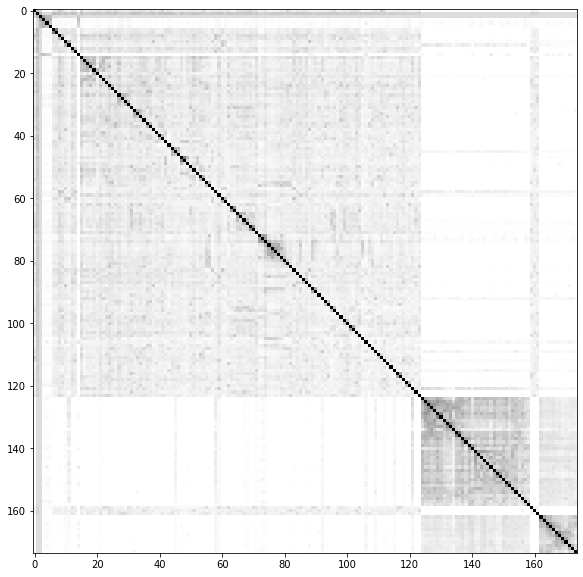

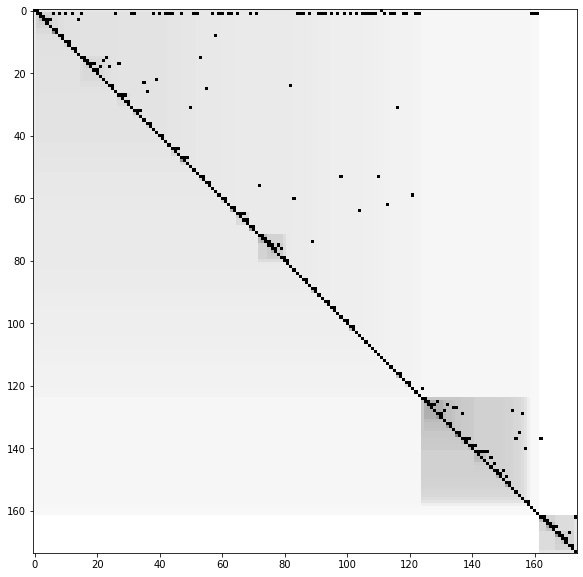

In [248]:
summary_writter = TfIdfModel(mode = 'agglomirate')
print(len(nltk.tokenize.sent_tokenize(text)))
output = summary_writter(text, n_sentences=30)

summary = output["Summary"]
hopkins_value = output["Metrics"]["Hopkins"]
silhouette_value = output["Metrics"]["Silhouette"]
html = output["Figures"]["html"]

In [239]:
print(summary)
hopkins_value, silhouette_value

Полковник Гурський з драгунами втік до Крилова, втративши понад 30 чоловік убитими.
Одна частина 12000 людей під проводом 26-річного Стефана Потоцького повинні були розбити 9-тисячне козацьке військо.
Коли начальники коронного війська, що стояло на Київщині, між Корсунем і Черкасами, гетьмани Миколай Потоцький і Марцін Калиновський дізналися про повстанські задуми Б.Хмельницького, вирішили зразу навесні йти на Запорожжя, задушити бунт у самому зародку, не допускаючи перекидання на всю Україну.
За аналогією ця варіантативність поширилася і на форми місцевого відмінка (на кораблеві, на місткові).
-и перейшов у звук [ɪ], закінчення мало бути -ови/-еви (подібні форми засвідчені в літературі як архаїчні), а наявне -ові можна пояснити впливом парадигми І відміни (жінці, рибі, руці), така ж заміна відбулася і в словах колишнього типу з основою на приголосний (імені, теляті, матері).
Світлина палаючого LZ 129 «Гінденбург» в 1937 році, подібного до того, який використовується на обкладинці дебю

(0.1923253113345671, 0.07651862414185584)

243


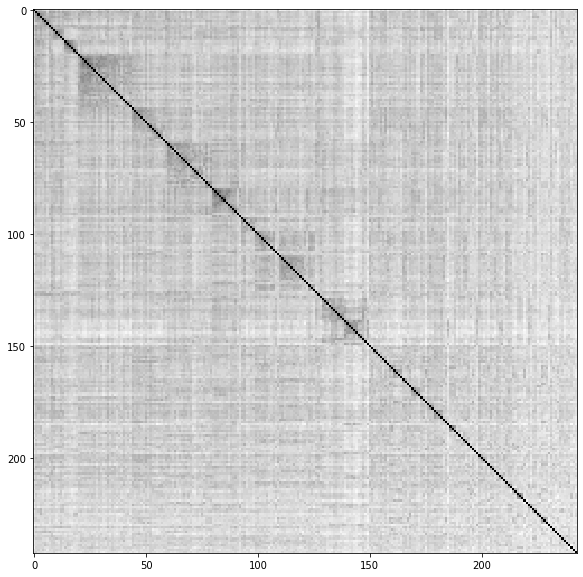

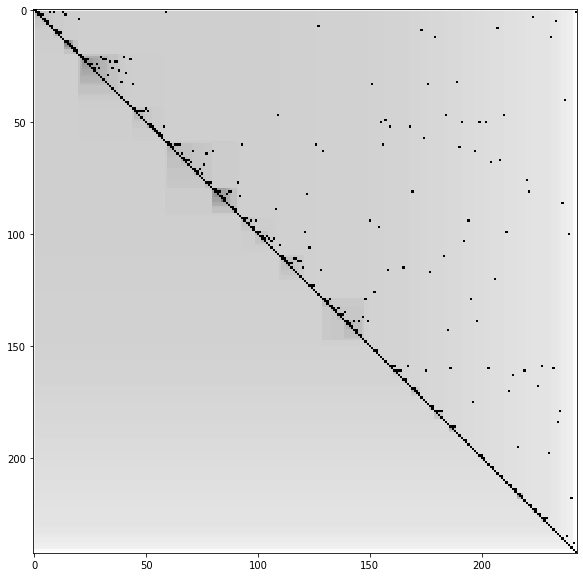

In [232]:
summary_writter = BertSummarizer(model, tokenizer, mode = 'agglomirate')
print(len(nltk.tokenize.sent_tokenize(text)))
output = summary_writter(text, n_sentences=12)

summary = output["Summary"]
hopkins_value = output["Metrics"]["Hopkins"]
silhouette_value = output["Metrics"]["Silhouette"]
vati = output["Figures"]["VAT"]
ivati = output["Figures"]["IVAT"]

In [234]:
print(summary)
hopkins_value, silhouette_value

Для розв'язання задачі ОУ будується математична модель об'єкта або процесу, яким управляють, яка буде проводити опис його поведінки з плином часу під впливом управляючих факторів.
Незважаючи на це, до моменту початку роботи над другим альбомом, керівництво Atlantic Records, що раніше тримало Led Zeppelin у фаворі, за словами Пейджа, «остаточно впало в екстаз» від гурту.
Кожен з гравців має 16 шахових фігур: вісім пішаків, дві тури, двох коней, двох слонів, ферзя та короля.
Наприклад, функція абсолютної величини y = |x| є неперервною в точці x = 0, але не є диференційовною в цій точці.
In November 1973, Malcolm and Angus Young formed AC/DC with bassist Larry Van Kriedt, vocalist Dave Evans, and ex-Masters Apprentices drummer Colin Burgess.
Промоклі щити, і луки римлян втратили боєздатність, бруд не давав можливості просуватися обозу і воїнам у важких обладунках, в той час як германці з легким озброєнням швидко переміщалися.
[3]  Близько 400 до н. е. згідно з Проклом, Платон дав метод ро

(0.40141029464497946, 0.044189587)

In [134]:
def get_vat_plot(matrix, title):
    p = figure(plot_width=350, plot_height=370,title=title, toolbar_location=None)
    p.image(image=[matrix], x=0, y=0, dw=2, dh=2, palette="Greys256")
    p.title.align = 'center'
    p.toolbar.active_drag = None
    p.toolbar.active_scroll = None
    p.toolbar.active_tap = None
    p.axis.visible = False
    p.grid.visible = False
    return p

In [241]:
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.io import output_notebook
from bokeh.layouts import row


p1 = get_vat_plot(vati, "Visual assessment of cluster tendency")
p2 = get_vat_plot(ivati, "iVAT")
p = row(p1, p2)
if False:
    show(p)
else:
    html = file_html(p, CDN, "ivat")

Loading BokehJS ...

In [243]:
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>ivat</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.2.3.min.js" integrity="sha384-T2yuo9Oe71Cz/I4X9Ac5+gpEa5a8PpJCDlqKYO0CfAuEszu1JrXLl8YugMqYe3sM" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="dea397e2-f92b-42b0-a3f9-b2cf80141dbb" data-root-id="1920"></div>
            
          
        
      
      
        <script type="application/json" id="2081">
          {"bfb2a592-4685-477d-b720-196b21f27d30":{"roots":{"references":[{"attributes":{},"id":"1854","type":"WheelZoomTool"},{"attributes":{},"id":"1889","type":"BasicTicker"},{"attributes":{"align"